# MNTD for transformer models

This notebook is for testing and developing the MNTD for transformer networks such as GPT.

## importing libraries

In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import os
import pickle

import random
import itertools

from mingpt.model import GPT
from model import setup_configs
from config import Detection
from utils import pickle_model


import matplotlib.pyplot as plt

Creating data points ...


In [2]:
# seeding for reproductivity
np.random.seed(10)

## Definitions of model, training and testing procedures

In [3]:
class MetaNetwork(nn.Module):
    def __init__(self, num_queries, num_classes=1):
        super().__init__()
        input_size = 28 * 42 * num_queries

        print(f"query size (input): {input_size}")

        self.queries = nn.Parameter(torch.rand(num_queries, 28, 128))

        self.affines = nn.Linear(input_size, 2048)
        self.norm1 = nn.LayerNorm(2048)
        self.relu1 = nn.ReLU(True)

        self.dropout = nn.Dropout(0.5)

        self.lin2 = nn.Linear(2048, 512)
        self.norm2 = nn.LayerNorm(512)
        self.relu2 = nn.ReLU(True)

        self.dropout2 = nn.Dropout(0.5)

        self.lin3 = nn.Linear(512, 128)
        self.norm3 = nn.LayerNorm(128)
        self.relu3 = nn.ReLU(True)

        self.final_output = nn.Linear(128, num_classes)
    
    def forward(self, net):
        """
        :param net: an input network of one of the model_types specified at init
        :param data_source: the name of the data source
        :returns: a score for whether the network is a Trojan or not
        """
        query = self.queries
        out, _ = net(embeded=query)

        out = out.view(1, -1)

        out = self.affines(out)
        out = self.norm1(out)
        out = self.relu1(out)

        out = self.dropout(out)

        out = self.lin2(out)
        out = self.norm2(out)
        out = self.relu2(out)

        out = self.dropout2(out)

        out = self.lin3(out)
        out = self.norm3(out)
        out = self.relu3(out)

        return self.final_output(out)

def load_models(path: str, train_partition: float = 0.7, max: int = None) -> tuple[tuple[nn.Module, int], tuple[nn.Module, int]]: 
    train = []
    test = []

    test_clean_count = 0
    train_clean_count = 0

    failed = []
    with os.scandir(path) as files:
        for i, file in enumerate(files): 
            if max is not None and i >= max: break
            try:
                with open(file.path, 'rb') as f:
                    checkpoint = pickle.load(f)
                    model_config, _ = setup_configs()
                    model = GPT(model_config)
                    model.load_state_dict(checkpoint)
                item = (
                    model,
                    0 if file.name.startswith("clean") else 1
                )
                if np.random.rand() < train_partition: 
                    train.append(item)
                    train_clean_count += file.name.startswith("clean")
                else: 
                    test.append(item)
                    test_clean_count += file.name.startswith("clean")
            except Exception:
                # print(f"corrupted pickle: {file.name}")
                failed.append(file.name)

    # test = np.random.permutation(test)
    # train = np.random.permutation(train)

    # random.shuffle(train)
    # random.shuffle(test)
    total = len(train) + len(test)
    total_clean = test_clean_count + train_clean_count


    print(f"Global partition: \n\t Total: {total} \n\tClean: {100*total_clean/total:.2f} \n\tTrojan: {100*(1 - total_clean/total):.2f}")
    print(f"Train partition: \n\tClean: {100 * train_clean_count / len(train):.2f}% \n\tTrojan: {100 * (1 - train_clean_count / len(train)) :.2f}%")
    print(f"Test partition: \n\tClean: {100 * test_clean_count / len(test):.2f}% \n\tTrojan: {100 * (1 - test_clean_count / len(test)) :.2f}%")


    if failed:
        with open("corrupted.sh", "w") as f:
            f.write("rm -f" + " ".join(failed))

    return train, test

def test_MNTD(model: nn.Module, data_models: tuple[nn.Module, int], lambda_l1: float = Detection.LAMBDA_L1) -> None:
    model.eval()
    loss_ema = np.inf
    loss = 0
    total = 0
    correct = 0

    for i, (net, label) in enumerate(data_models):
        net.eval()
        out = model(net)
        loss = F.binary_cross_entropy_with_logits(out, torch.FloatTensor([label]).unsqueeze(0))
        # loss.backward(inputs=list(model.parameters()))
        # model.queries.data = model.queries.data.clamp(0, 1)
        loss_ema = loss.item() if loss_ema == np.inf else 0.95 * loss_ema + 0.05 * loss.item()
        loss += loss_ema
        loss += sum(lambda_l1 * torch.norm(parameter, 1) for parameter in model.parameters()) ## L1 regularization
        
        # print(out.item(), label)
        correct += (out.item() - 1/2) * (label - 1/2) > 0
        total += 1

    print(f"loss {loss}")
    print(f"acuracy: {correct/total:.5f}")
    return loss, correct/total


def train_MNTD(model: nn.Module, data_models: tuple[nn.Module, int], validation_split: float = 0.3, 
        lambda_l1: float = Detection.LAMBDA_L1, weight_decay: float = Detection.WEIGHT_DECAY, learning_rate: float = Detection.LEARNING_RATE,
        plot: bool = True, backup_name: str = "meta"
    ) -> None:
    print("training model\n\n")

    np.random.shuffle(data_models)
    partition_point = int(len(data_models)*validation_split)
    validation_data_models = data_models[:partition_point]
    train_data_models = data_models[partition_point:]

    print(f"Train partition: {len(train_data_models)}")
    print(f"Validation partition: {len(validation_data_models)}")

    model.train()
    num_epochs = Detection.NUM_EPOCHS
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs * len(train_data_models))

    loss_ema = np.inf

    test_losses = []
    train_losses = []
    test_accuracies = []

    best_model = None
    best_model_loss = float('inf')
    best_model_accuracy = 0


    try:
        for epoch in range(num_epochs):
            epoch_loss = 0 

            model.train()
            for i, (net, label) in enumerate(train_data_models):
                net.eval()

                out = model(net)

                loss = F.binary_cross_entropy_with_logits(out, torch.FloatTensor([label]).unsqueeze(0))
                loss += sum(lambda_l1 * torch.norm(parameter, 1) for parameter in model.parameters()) ## L1 regularization

                optimizer.zero_grad()
                loss.backward(inputs=list(model.parameters()))
                optimizer.step()
                scheduler.step()
                model.queries.data = model.queries.data.clamp(0, 1)
                loss_ema = loss.item() if loss_ema == np.inf else 0.95 * loss_ema + 0.05 * loss.item()
                epoch_loss += loss_ema

            print("\nValidation batch:")
            test_loss, test_acc = test_MNTD(model, validation_data_models)
            test_losses.append(test_loss.item())
            test_accuracies.append(test_acc)
            train_losses.append(epoch_loss)

            print(f"train batch: epoch {epoch} - loss {epoch_loss}")

            if plot:
                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
                ax1.plot(test_losses)
                ax1.set_title('Test losses')

                ax2.plot(train_losses)
                ax2.set_title('Train losses')

                ax3.plot(test_accuracies)
                ax3.set_title('Test Accuracy')

                plt.show()

            # saving best result from loss measure
            # if test_loss < best_model_loss:
            #     best_model_loss = test_loss
            #     best_model = model.state_dict()

            # saving best result from accuracy measure
            if test_acc > best_model_accuracy:
                best_model_accuracy = test_acc
                best_model = model.state_dict()

            # pickle_model("backup", f"{backup_name}_{epoch}",  model)

    finally:
        return test_losses, test_accuracies, train_losses, best_model

## Hyper parameters fine tuning cell

In [4]:
# Fine tunning the hyperparameters
# train, test = load_models("/run/media/guilherme.vieira-manhaes/UBUNTU 22_1/psc/finals", .7, max=2000)

# lambda_l1 = [1e-5, 1e-4, 1e-3]
# lambda_l2 = [1e-5, 1e-4, 1e-3]
# learning_rate = [1e-5, 1e-4]


# # checking for already tested configs
# with open("hyper_used.csv", "r") as f:
#     lines = f.readlines()

# used = set(
#     tuple(
#         map(lambda n: float(n), line.rstrip("/n").split(","))
#     ) for line in lines
# )

# for l1, l2, lr in itertools.product(lambda_l1, lambda_l2, learning_rate):
#     if (l1, l2, lr) in used: continue
#     meta_network = MetaNetwork(Detection.NUM_QUERIES)
#     test_losses, test_acc, train_losses, best_model = train_MNTD(meta_network, train, validation_split=0.1,
#         lambda_l1=l1, weight_decay=l2, learning_rate=lr, plot=False, backup_name=f"{l1}_{l2}_{lr}"
#     )
#     loss, accuracy = test_MNTD(meta_network, test)
#     pickle_model("hypertuning", f"meta_l1_{l1}_l2_{l2}_lr_{lr}_acc_{accuracy:.3f}", meta_network)
#     with open("hyper.csv", "a") as f:
#         f.write(f"{accuracy}, {l1}, {l2}, {lr}\n")
#     with open("hyper_used.csv", "a") as f:
#         f.write(f"{l1},{l2},{lr}\n")
    

## Training the actual model

In [6]:
train, test = load_models("/run/media/guilherme.vieira-manhaes/UBUNTU 22_1/psc/finals", .8)

Global partition: 
	 Total: 4774 
	Clean: 49.58 
	Trojan: 50.42
Train partition: 
	Clean: 50.01% 
	Trojan: 49.99%
Test partition: 
	Clean: 47.77% 
	Trojan: 52.23%


query size (input): 11760
training model


Train partition: 3470
Validation partition: 385

Validation batch:
loss 8.185018539428711
acuracy: 0.52208
train batch: epoch 0 - loss 49853.28446506371


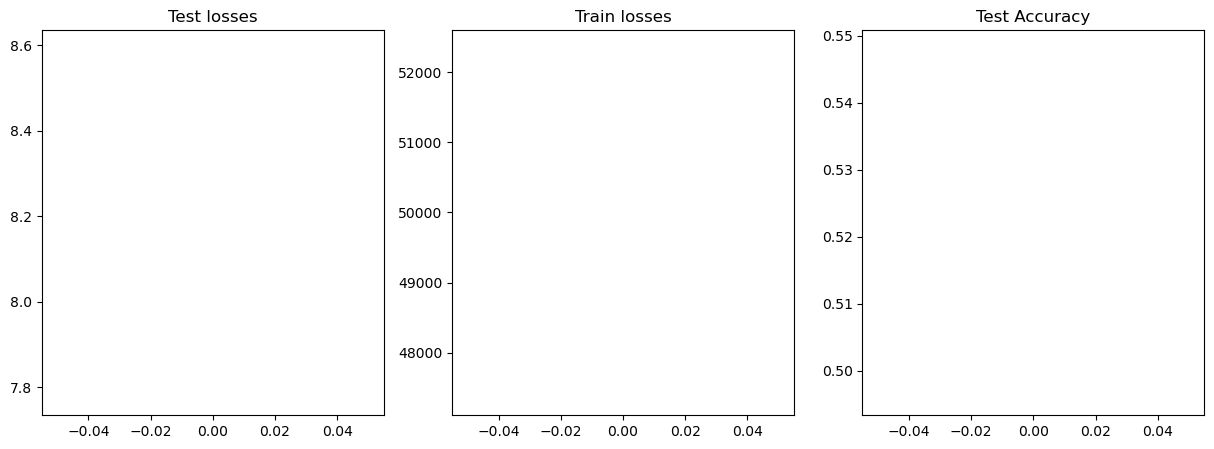


Validation batch:
loss 6.58110237121582
acuracy: 0.54545
train batch: epoch 1 - loss 23697.441689819752


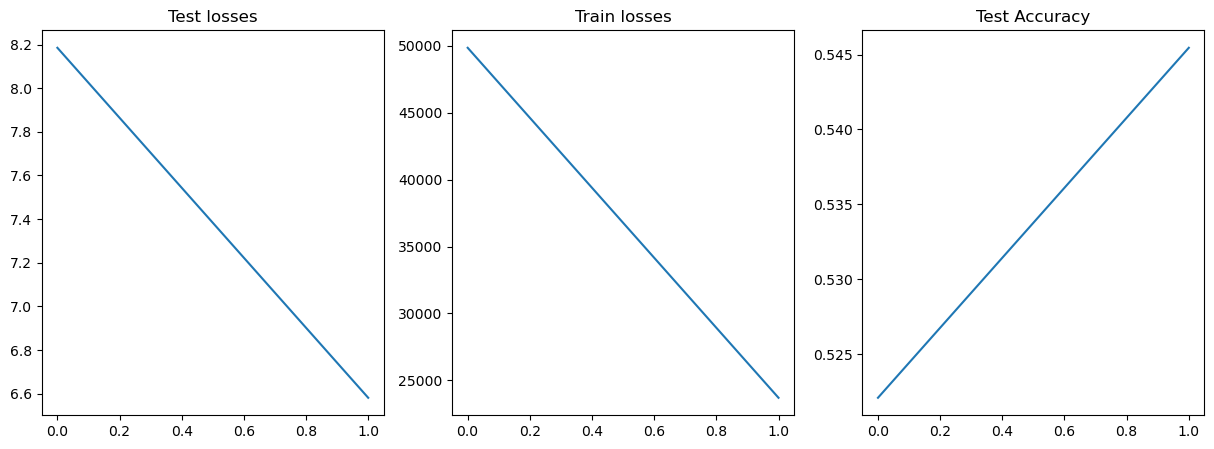


Validation batch:
loss 5.785037040710449
acuracy: 0.58961
train batch: epoch 2 - loss 19899.769237107073


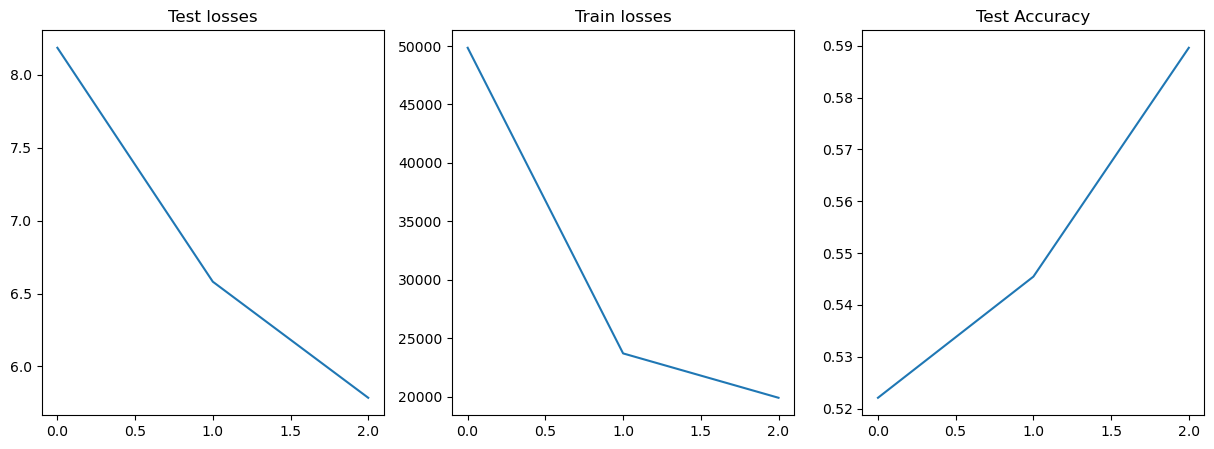


Validation batch:
loss 5.118614196777344
acuracy: 0.64935
train batch: epoch 3 - loss 17740.938611567126


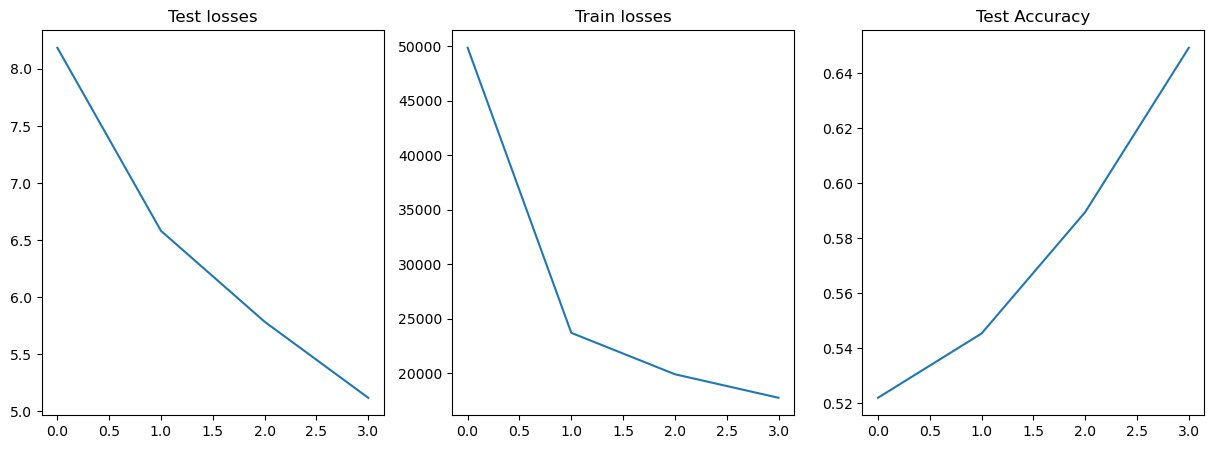


Validation batch:
loss 4.77351188659668
acuracy: 0.67013
train batch: epoch 4 - loss 16372.959720979949


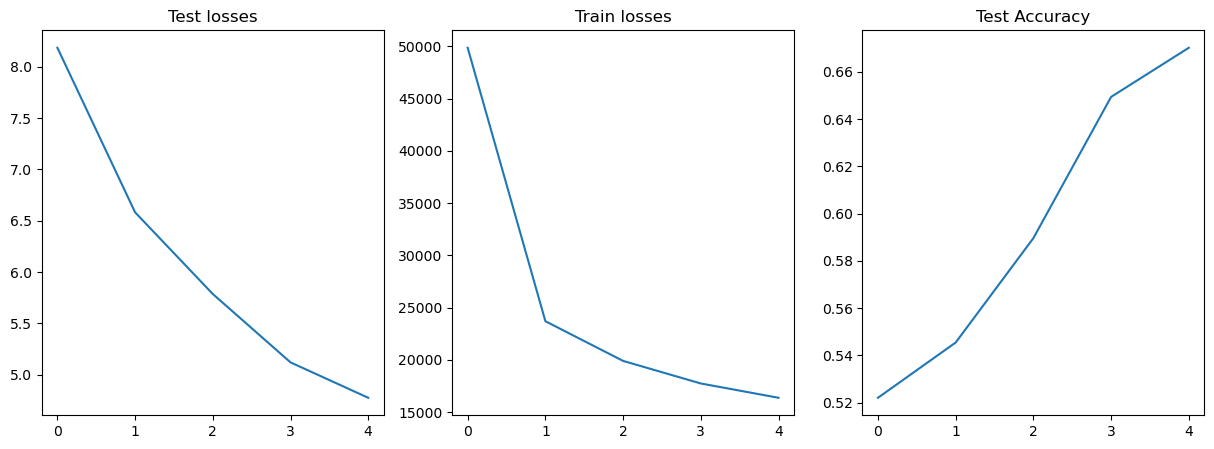


Validation batch:
loss 4.4054365158081055
acuracy: 0.64935
train batch: epoch 5 - loss 15285.041247168268


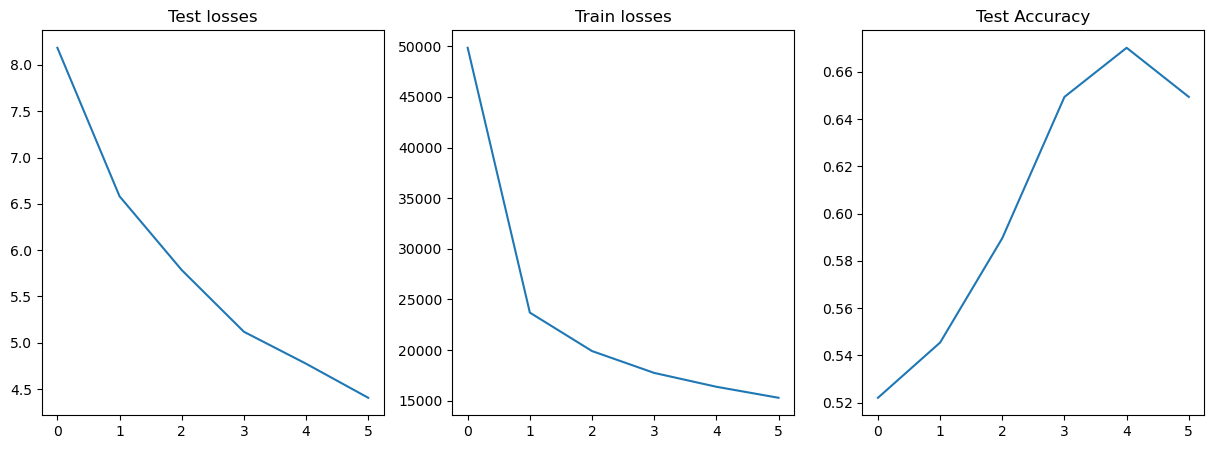


Validation batch:
loss 4.191811561584473
acuracy: 0.67792
train batch: epoch 6 - loss 14371.720227324742


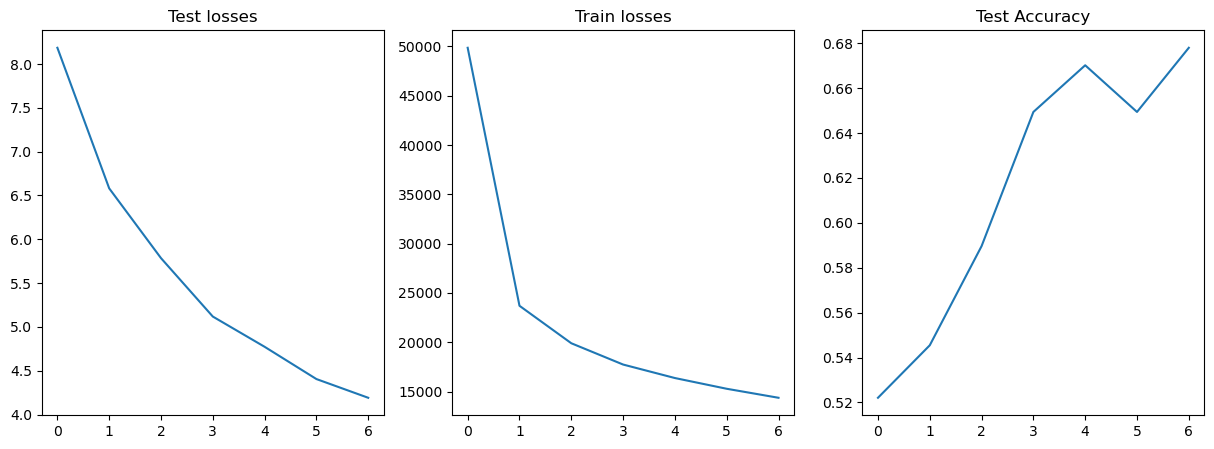


Validation batch:
loss 4.090286731719971
acuracy: 0.69091
train batch: epoch 7 - loss 13763.251806264427


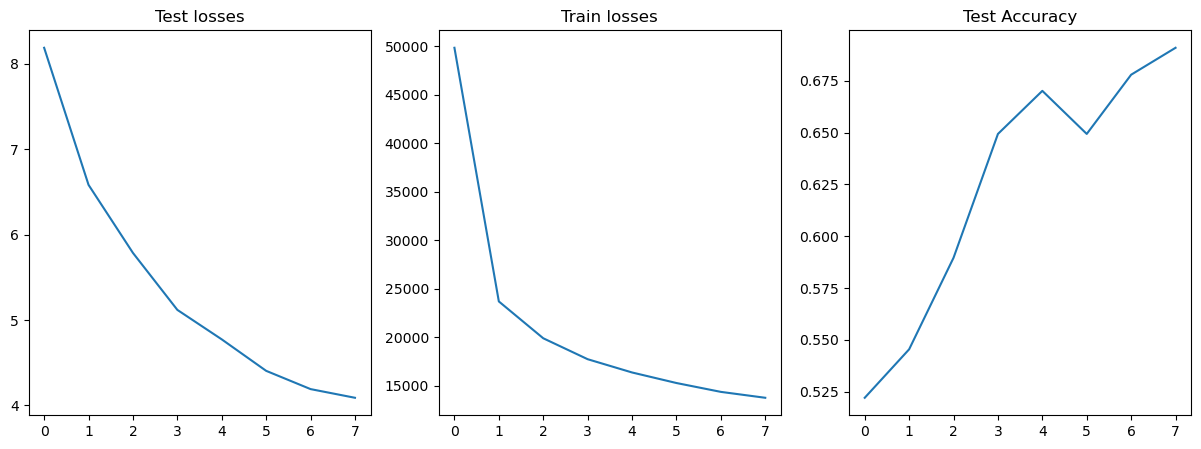


Validation batch:
loss 4.00930643081665
acuracy: 0.68571
train batch: epoch 8 - loss 13370.897740749273


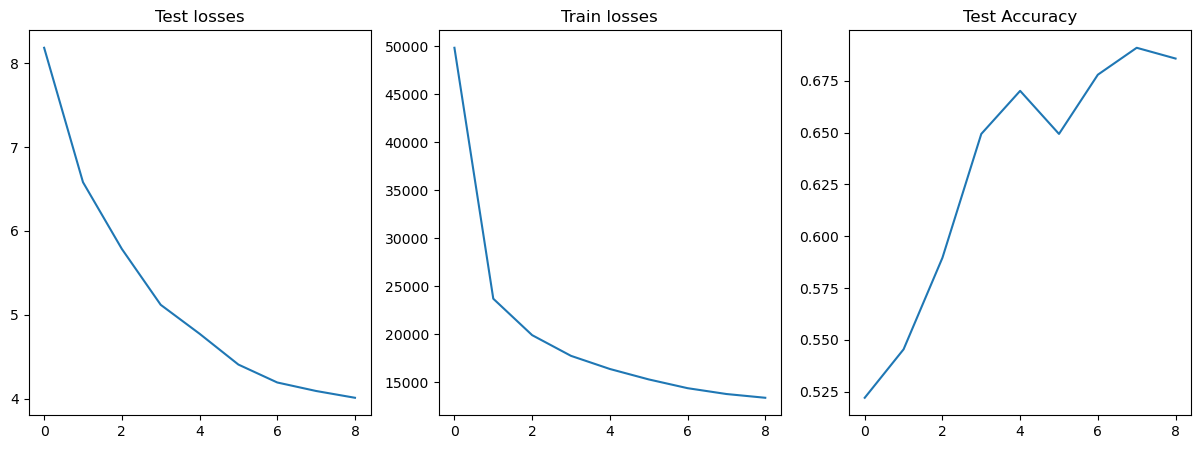


Validation batch:
loss 3.8456878662109375
acuracy: 0.70649
train batch: epoch 9 - loss 13026.398082165273


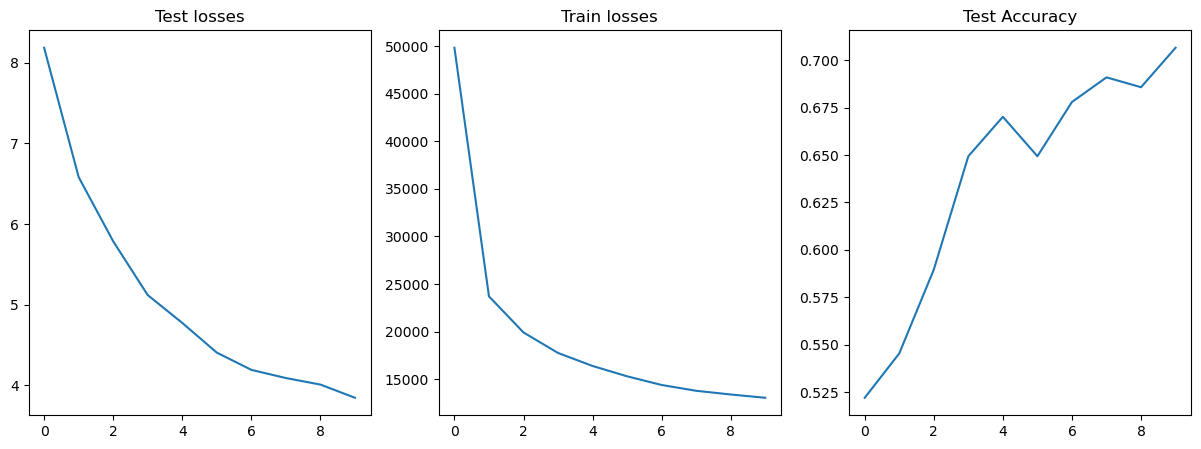


Validation batch:
loss 3.7637288570404053
acuracy: 0.68831
train batch: epoch 10 - loss 12732.364601361878


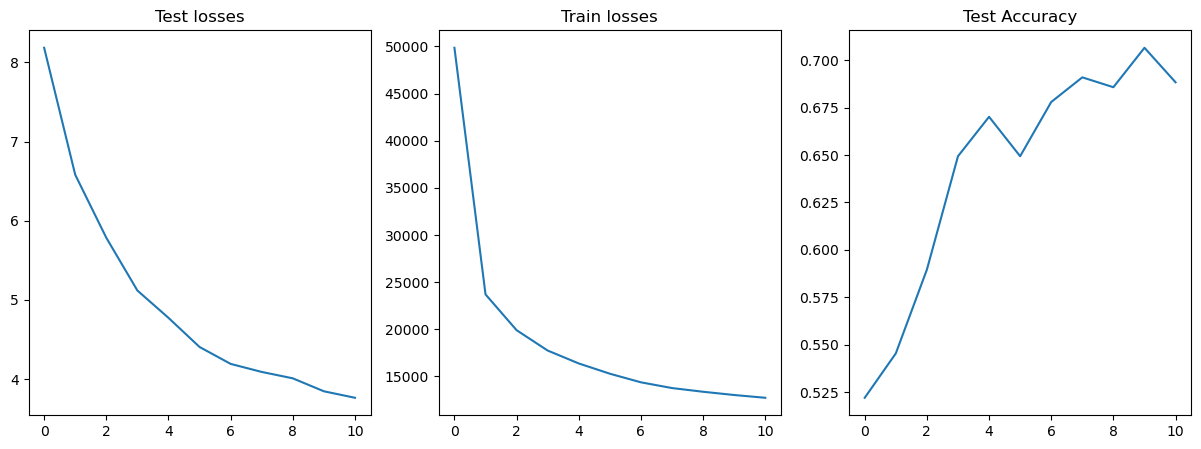


Validation batch:
loss 3.6792402267456055
acuracy: 0.69610
train batch: epoch 11 - loss 12489.022312730416


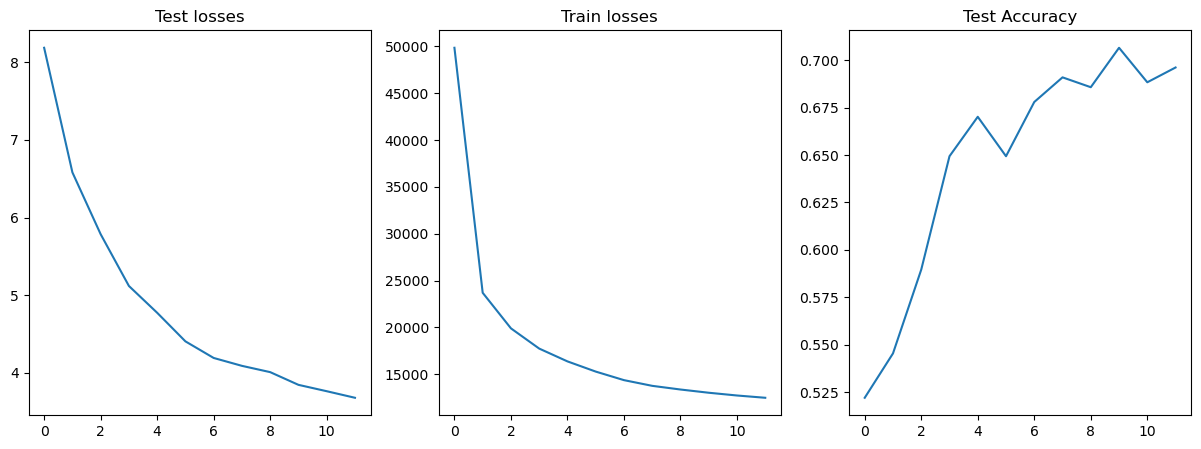


Validation batch:
loss 3.718120574951172
acuracy: 0.71169
train batch: epoch 12 - loss 12227.311331323826


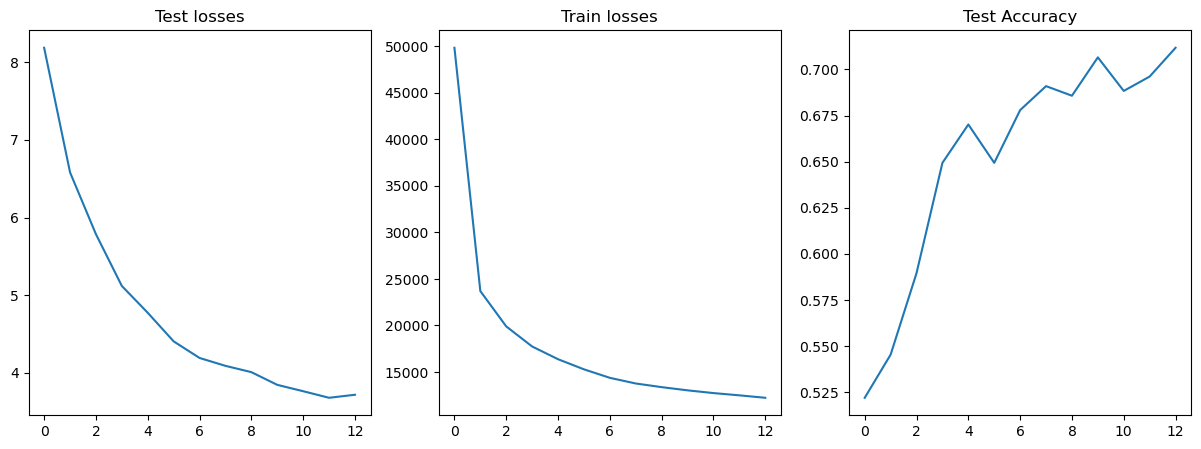


Validation batch:
loss 3.625354766845703
acuracy: 0.68831
train batch: epoch 13 - loss 12011.554207350171


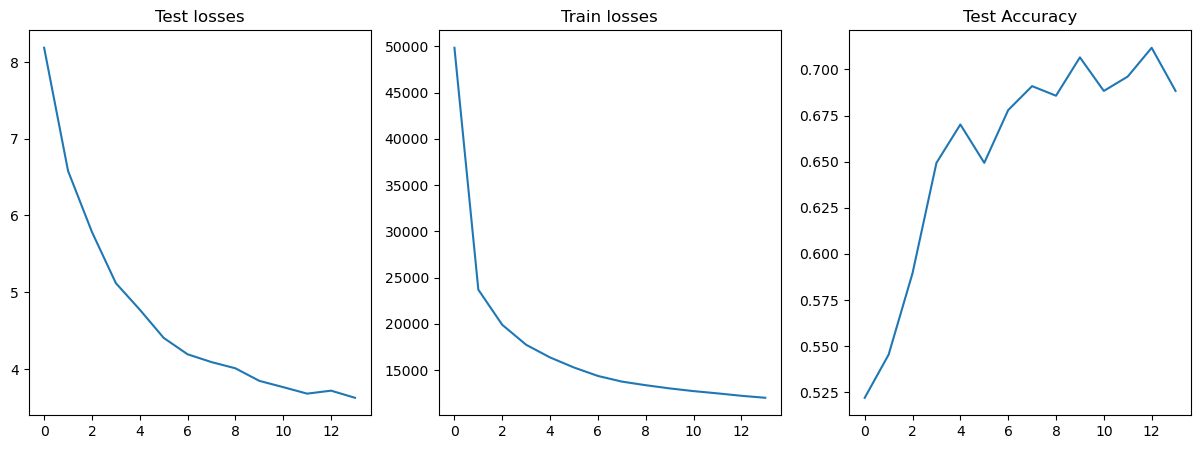


Validation batch:
loss 3.4359893798828125
acuracy: 0.72208
train batch: epoch 14 - loss 11857.79589667704


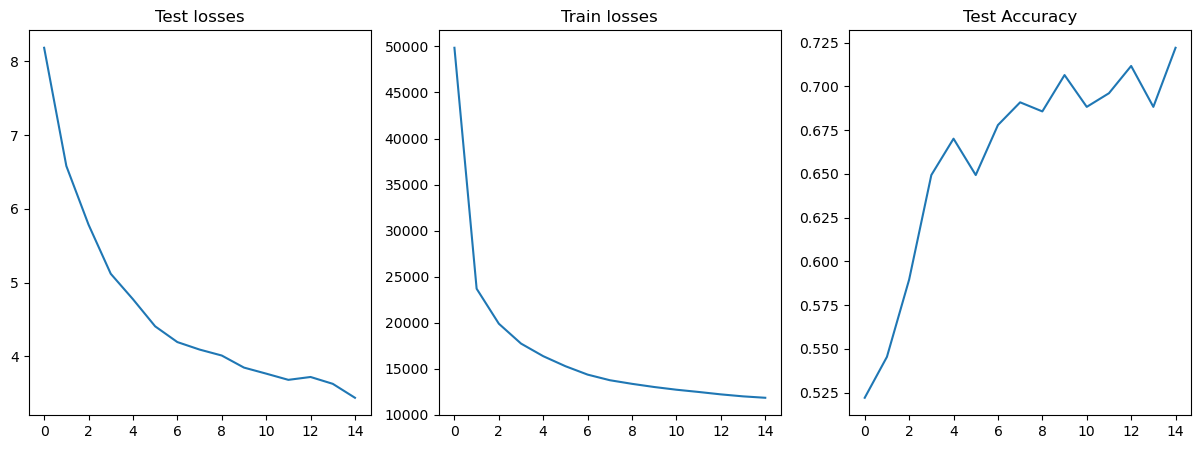


Validation batch:
loss 3.459465503692627
acuracy: 0.72987
train batch: epoch 15 - loss 11643.433879203645


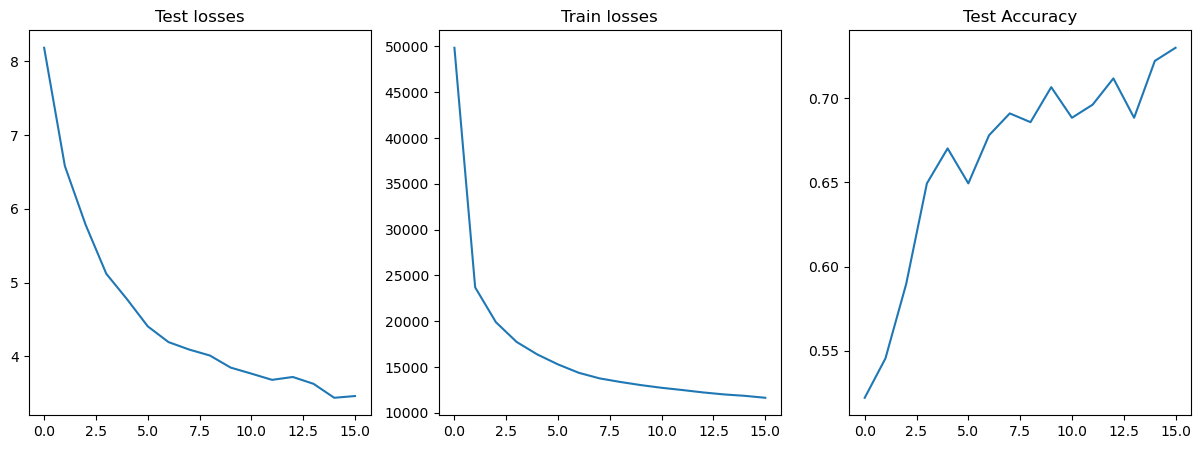


Validation batch:
loss 3.470292091369629
acuracy: 0.72208
train batch: epoch 16 - loss 11534.431582861867


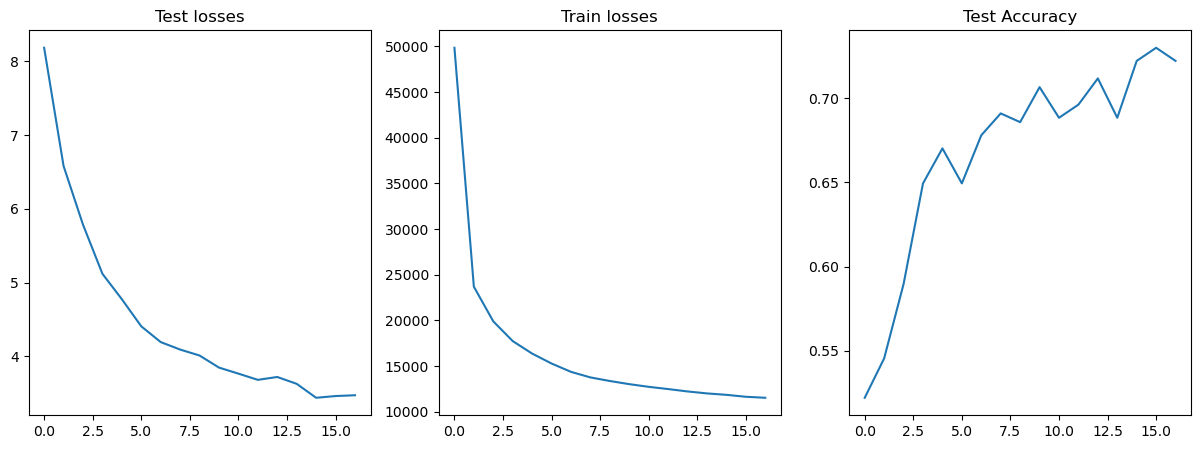


Validation batch:
loss 3.412466526031494
acuracy: 0.70649
train batch: epoch 17 - loss 11371.537417544812


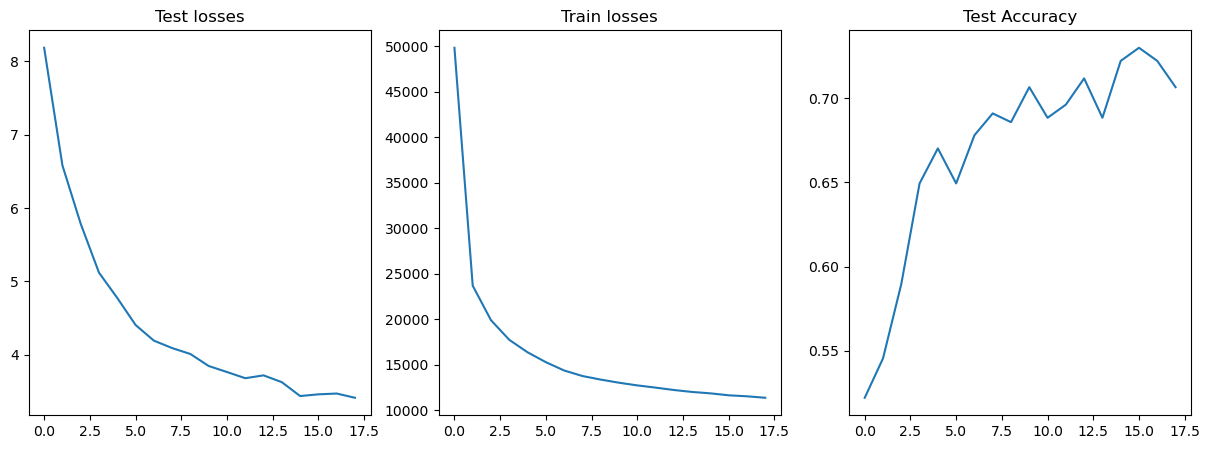


Validation batch:
loss 3.399488687515259
acuracy: 0.72468
train batch: epoch 18 - loss 11229.854220458921


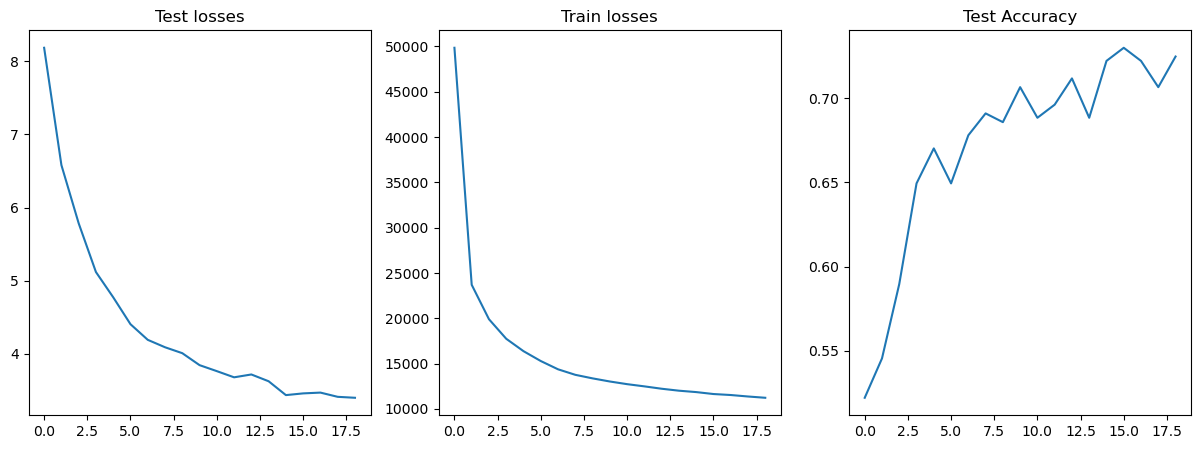


Validation batch:
loss 3.3683831691741943
acuracy: 0.73247
train batch: epoch 19 - loss 11156.66760643519


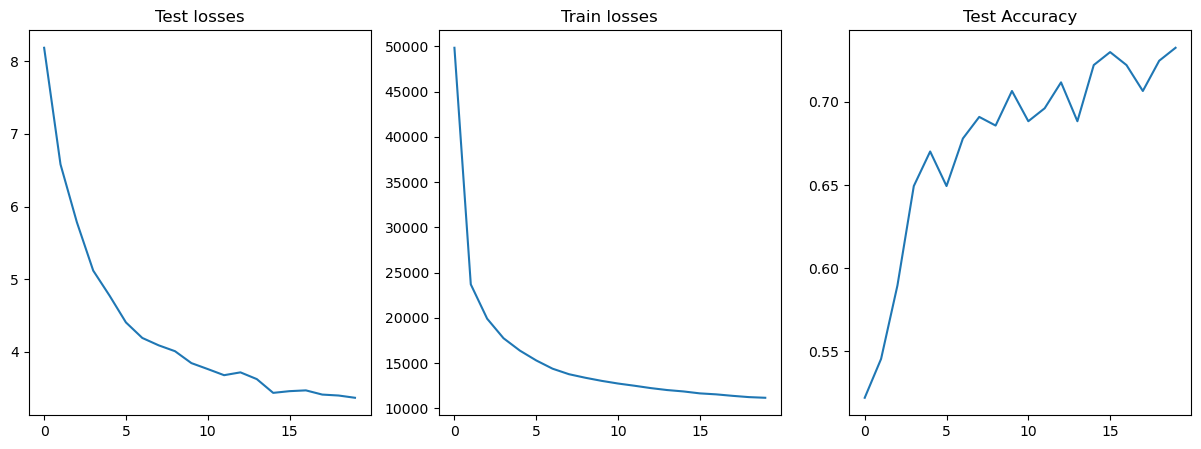


Validation batch:
loss 3.319550037384033
acuracy: 0.72987
train batch: epoch 20 - loss 11000.65044199299


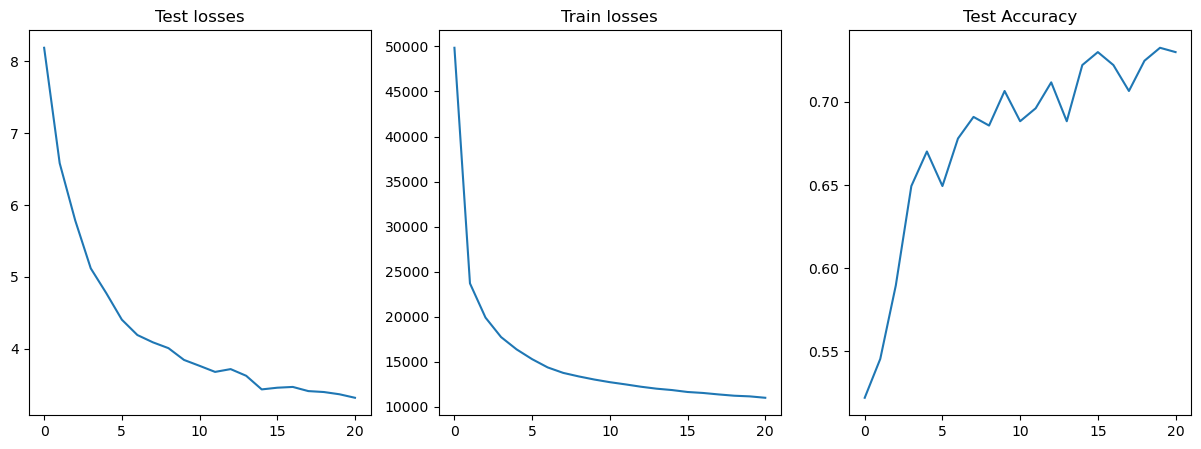


Validation batch:
loss 3.3868463039398193
acuracy: 0.72987
train batch: epoch 21 - loss 10857.645385903734


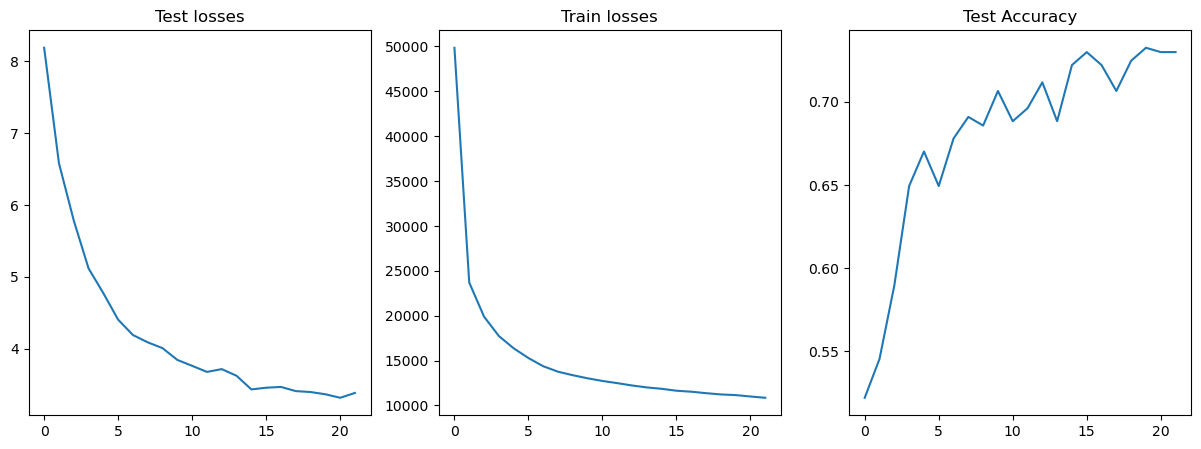


Validation batch:
loss 3.344054937362671
acuracy: 0.73766
train batch: epoch 22 - loss 10810.059915856846


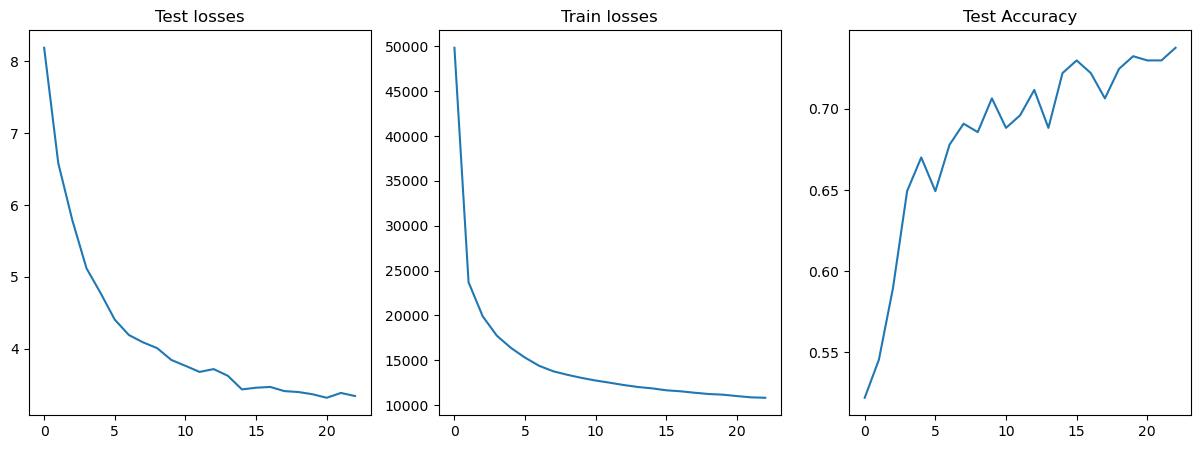


Validation batch:
loss 3.3721871376037598
acuracy: 0.72468
train batch: epoch 23 - loss 10671.108388802113


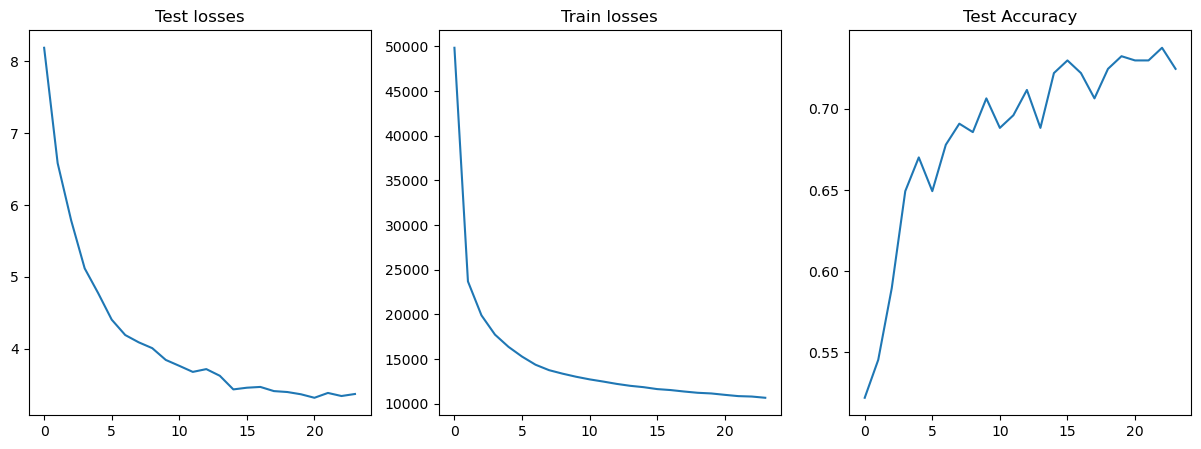


Validation batch:
loss 3.3425562381744385
acuracy: 0.73506
train batch: epoch 24 - loss 10578.001715192457


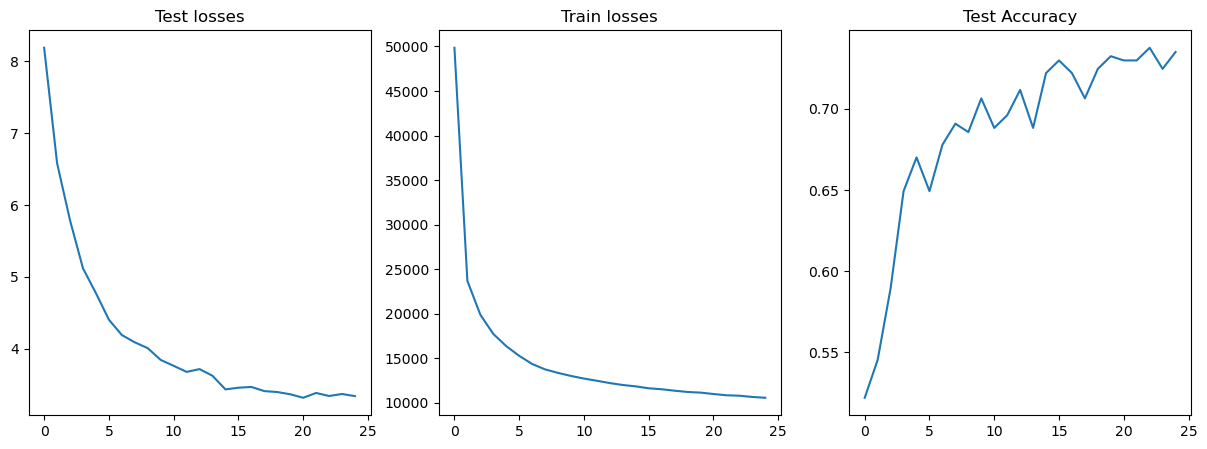


Validation batch:
loss 3.3383827209472656
acuracy: 0.73766
train batch: epoch 25 - loss 10527.899092806249


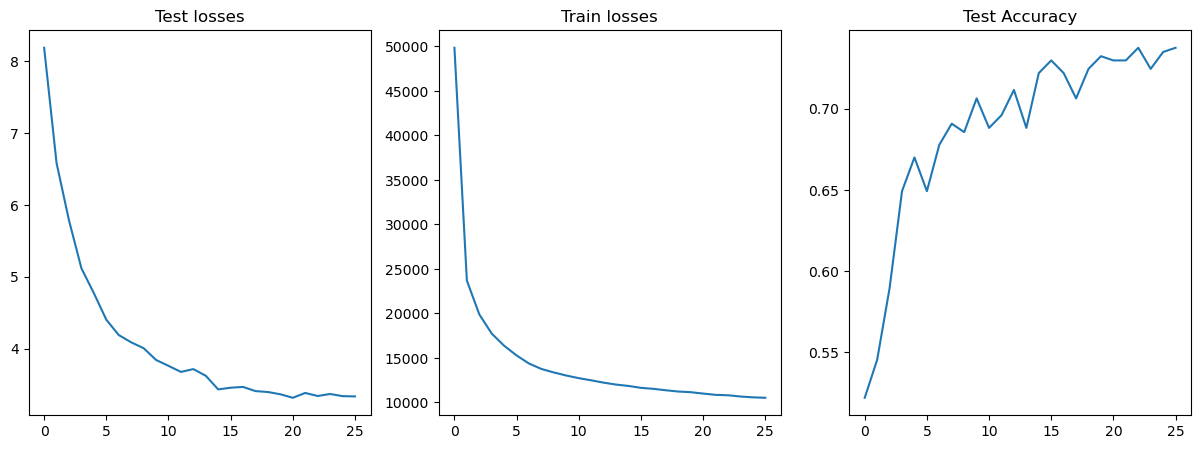


Validation batch:
loss 3.3358242511749268
acuracy: 0.74286
train batch: epoch 26 - loss 10401.020039335244


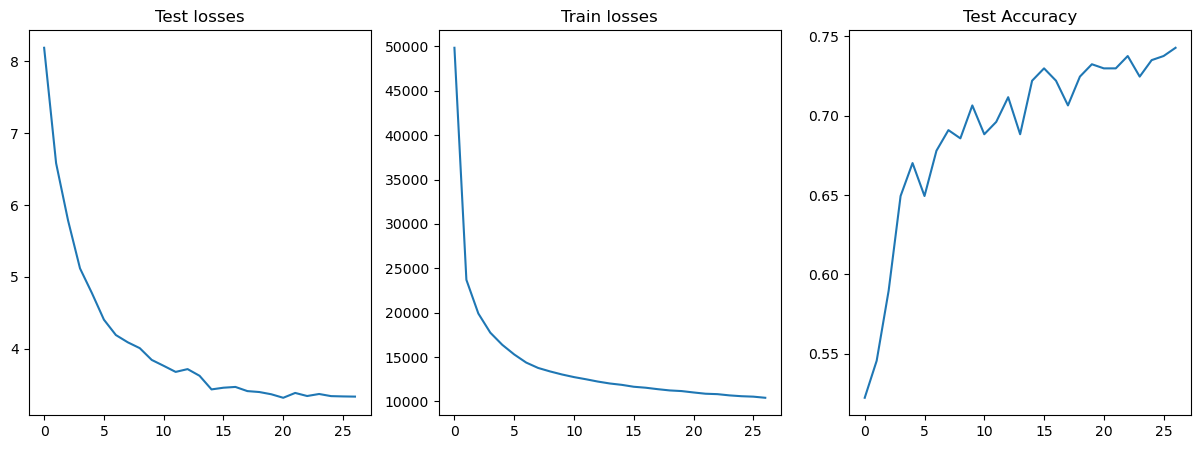


Validation batch:
loss 3.3867454528808594
acuracy: 0.75584
train batch: epoch 27 - loss 10373.559669020924


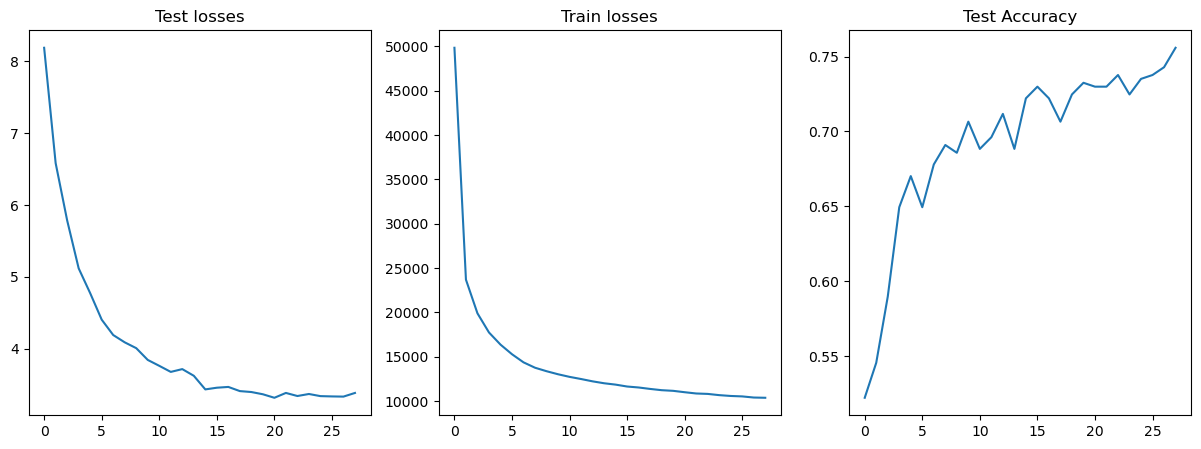


Validation batch:
loss 3.341500997543335
acuracy: 0.75325
train batch: epoch 28 - loss 10256.38045361521


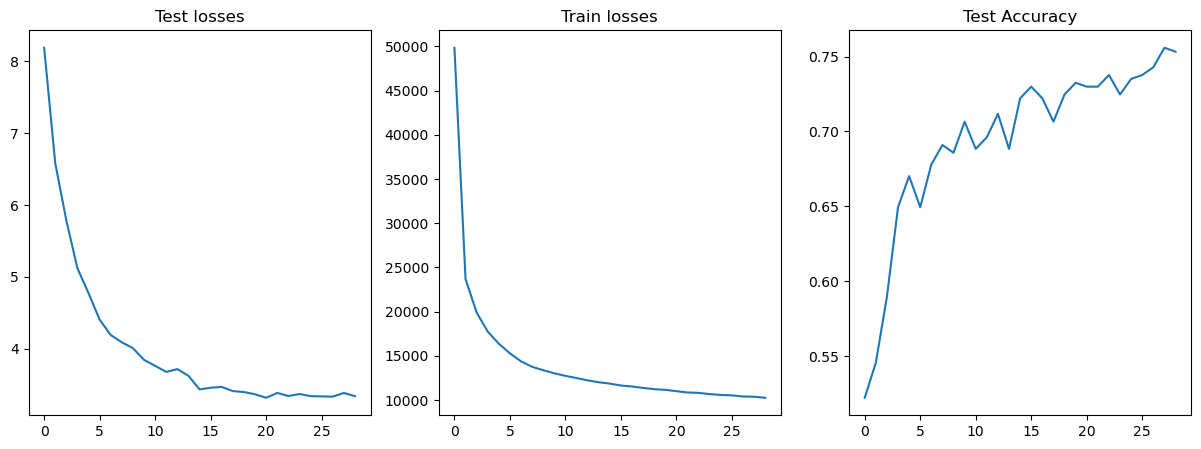


Validation batch:
loss 3.3740899562835693
acuracy: 0.73506
train batch: epoch 29 - loss 10166.907700614585


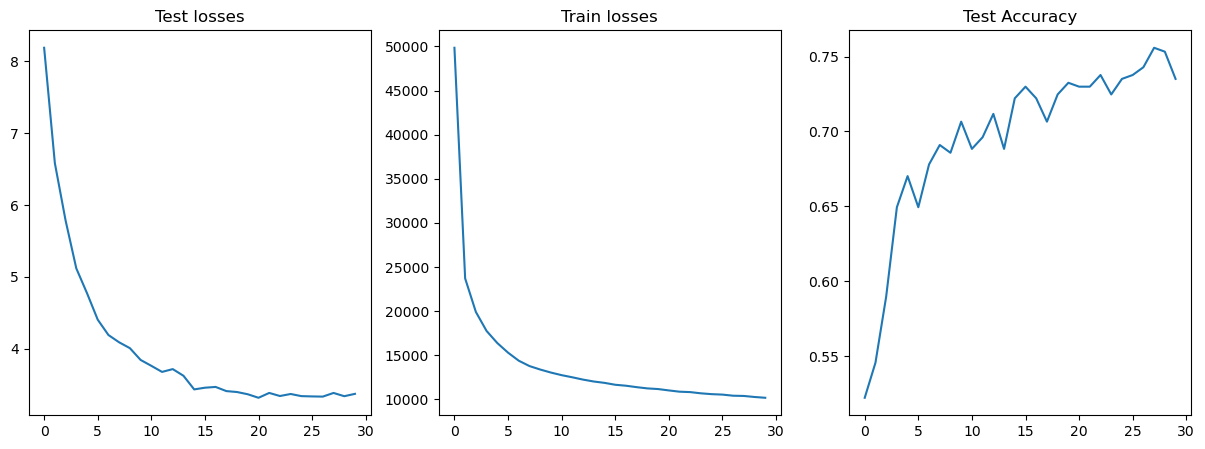


Validation batch:
loss 3.367161273956299
acuracy: 0.74805
train batch: epoch 30 - loss 10156.345291118143


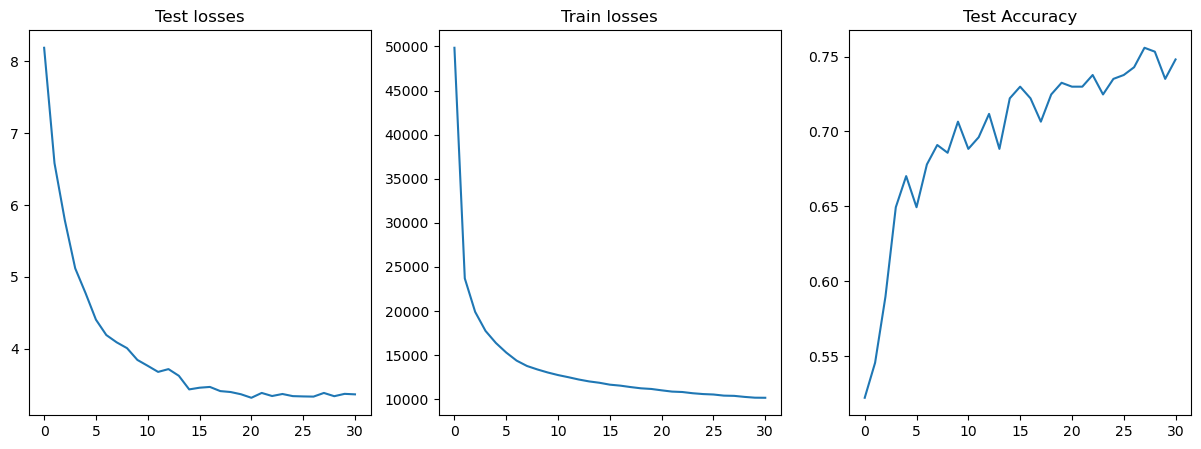


Validation batch:
loss 3.35392427444458
acuracy: 0.75584
train batch: epoch 31 - loss 10098.775797805107


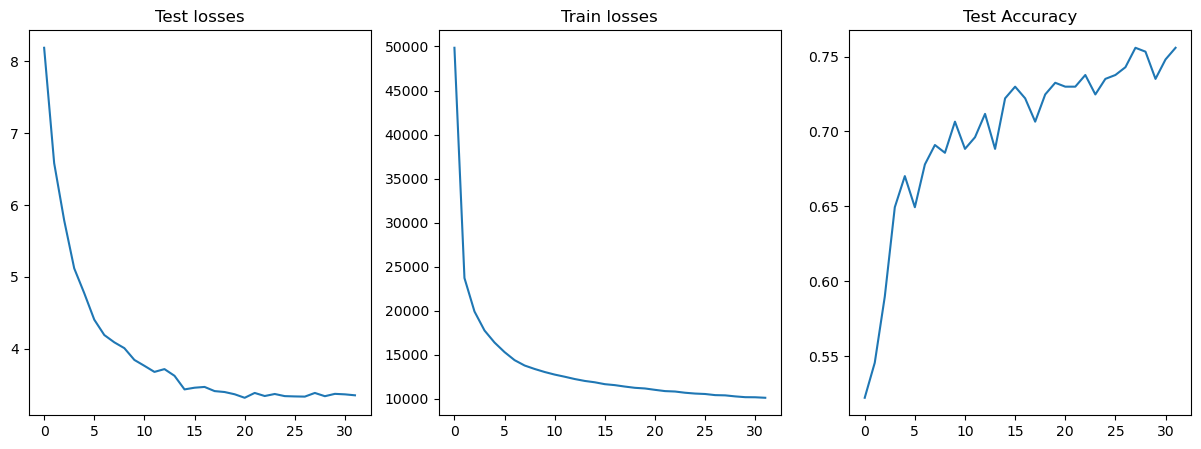


Validation batch:
loss 3.3734185695648193
acuracy: 0.74805
train batch: epoch 32 - loss 10042.804187207714


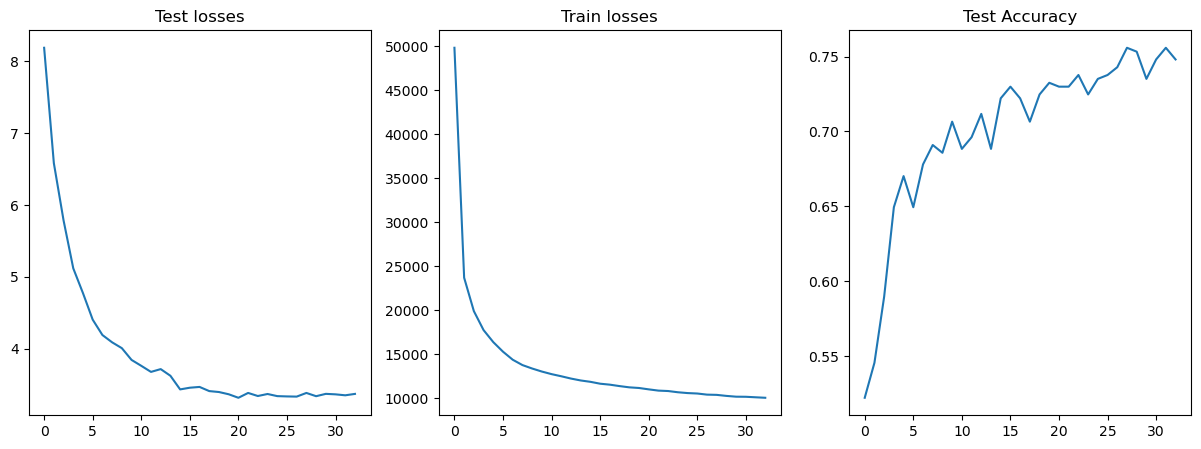


Validation batch:
loss 3.361745834350586
acuracy: 0.75065
train batch: epoch 33 - loss 10006.200559364208


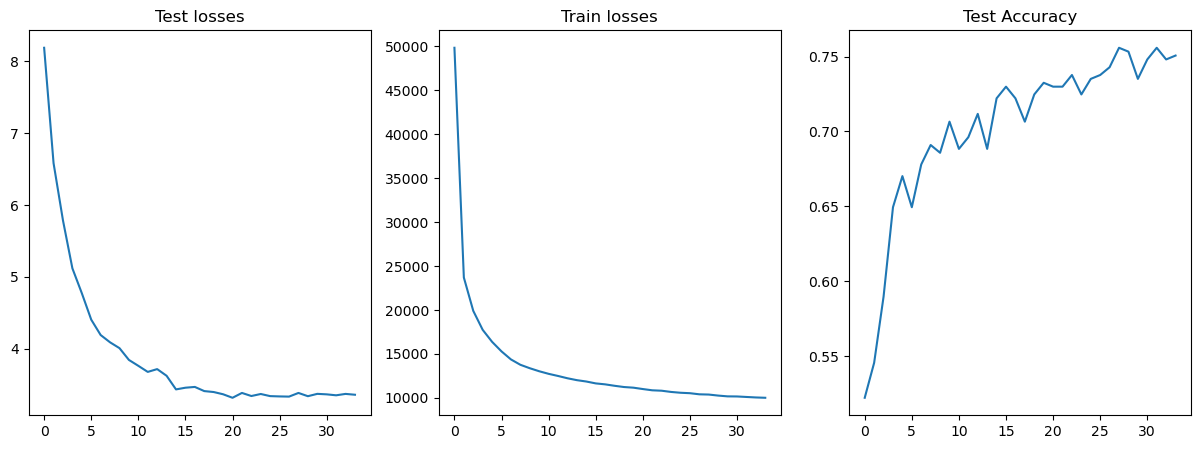


Validation batch:
loss 3.387122392654419
acuracy: 0.75325
train batch: epoch 34 - loss 9976.406702297749


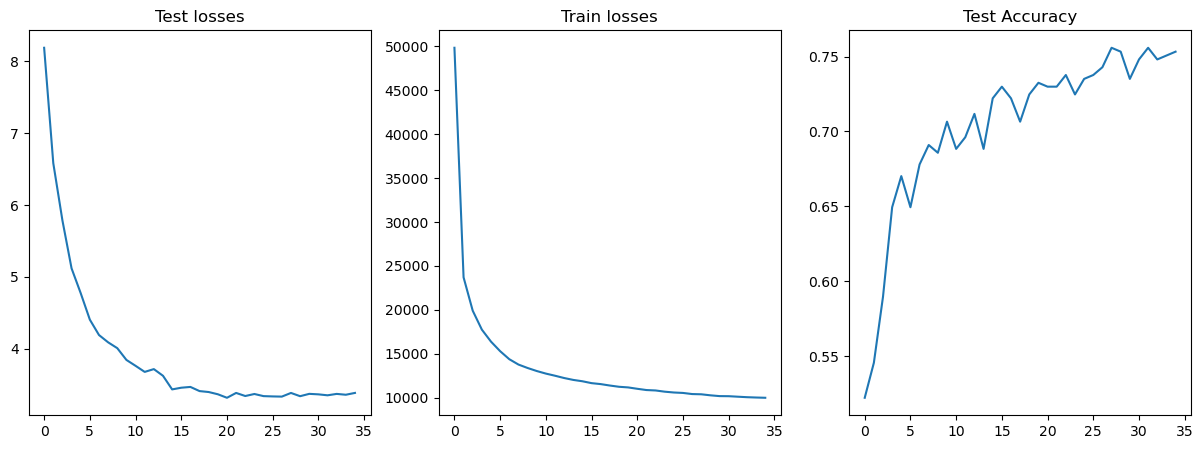


Validation batch:
loss 3.3584625720977783
acuracy: 0.75325
train batch: epoch 35 - loss 9924.945114362417


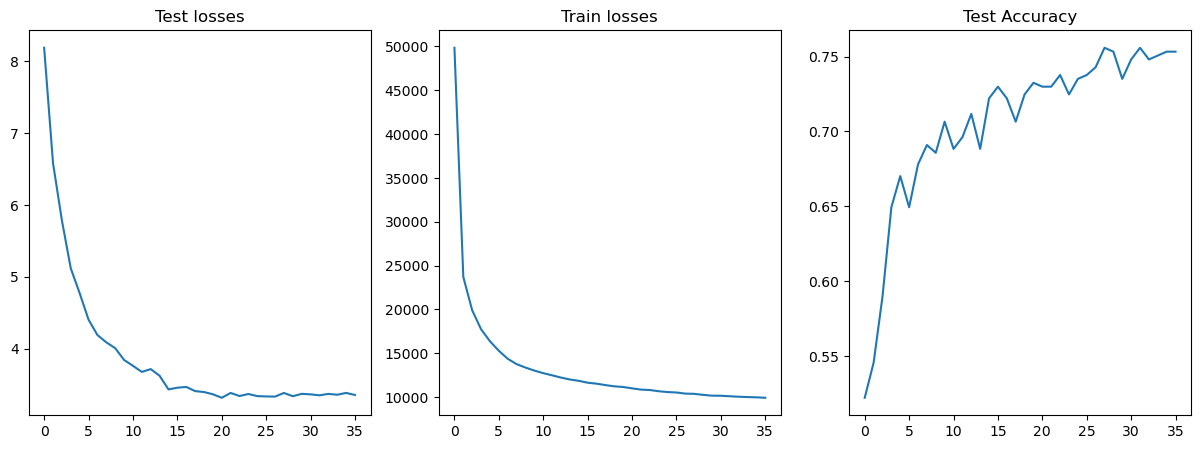


Validation batch:
loss 3.365025520324707
acuracy: 0.76104
train batch: epoch 36 - loss 9856.994707087959


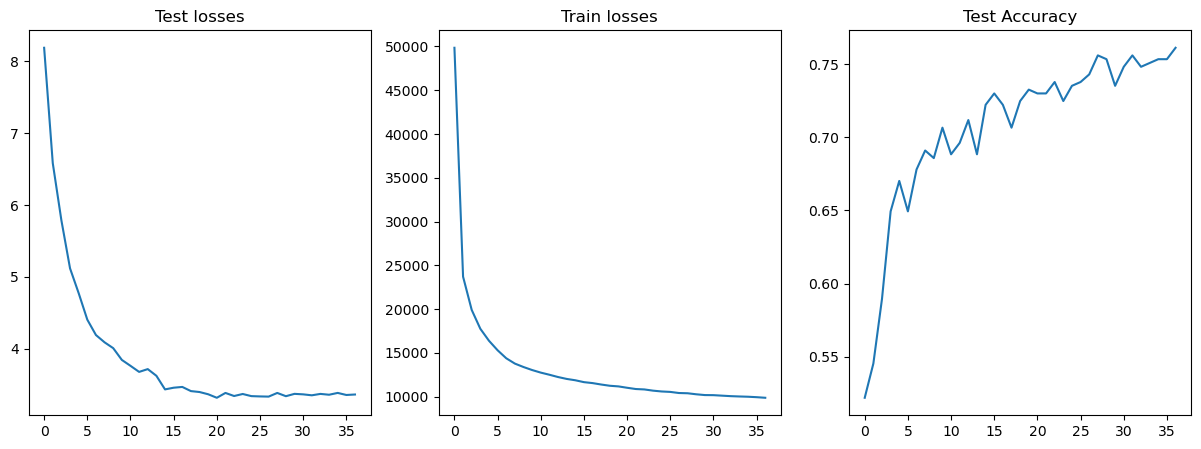


Validation batch:
loss 3.3727855682373047
acuracy: 0.75584
train batch: epoch 37 - loss 9862.015471018534


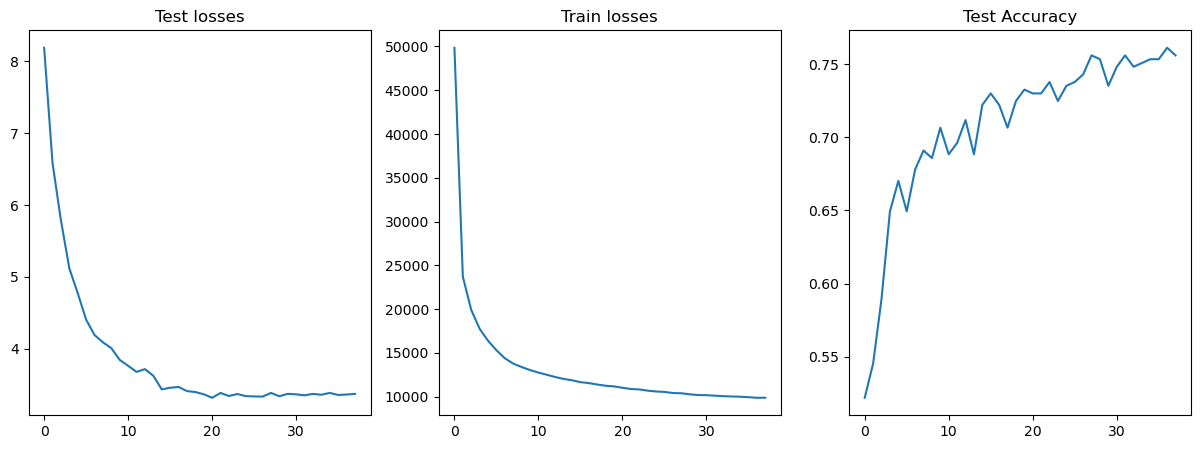


Validation batch:
loss 3.371253728866577
acuracy: 0.75584
train batch: epoch 38 - loss 9833.949388690555


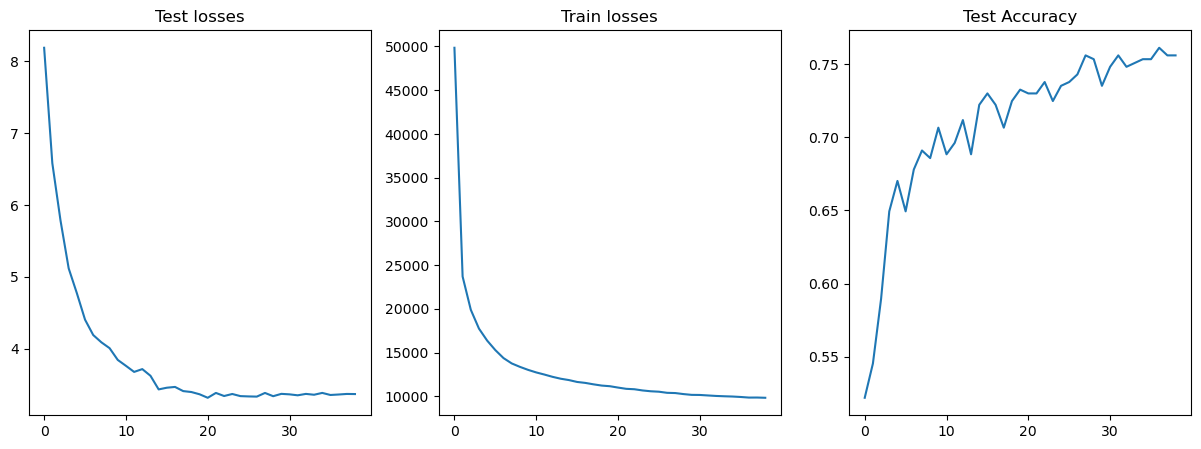


Validation batch:
loss 3.370695114135742
acuracy: 0.75584
train batch: epoch 39 - loss 9848.184456328827


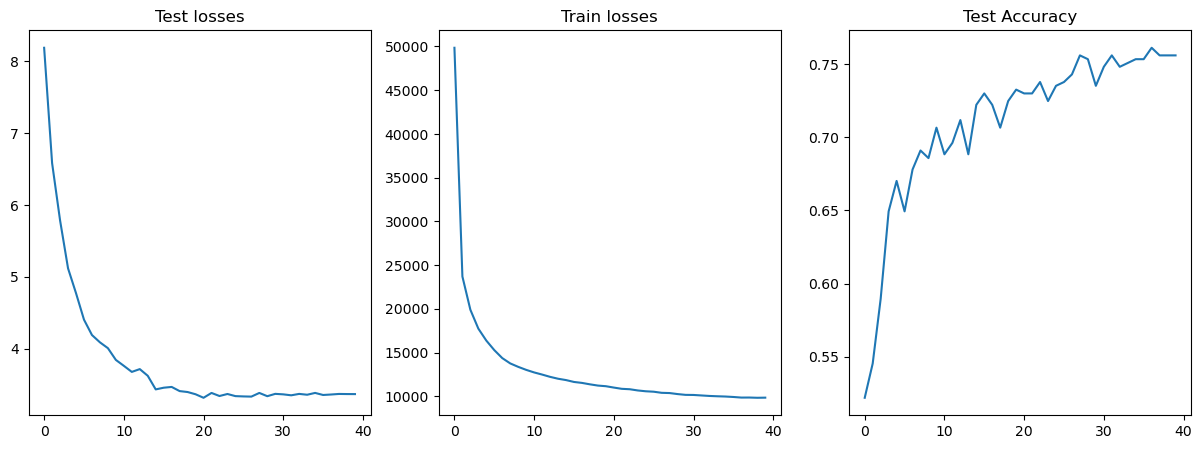

In [7]:
meta_network = MetaNetwork(Detection.NUM_QUERIES)
test_losses, test_acc, train_losses, best_model = train_MNTD(meta_network, train, validation_split=0.1)

In [11]:
test_MNTD(meta_network, test)

loss 6.8521013259887695
acuracy: 0.72144


(tensor(6.8521, grad_fn=<AddBackward0>), 0.721436343852013)

In [8]:
net = MetaNetwork(Detection.NUM_QUERIES)
net.load_state_dict(best_model)
test_MNTD(net, test)

query size (input): 11760
loss 6.852289199829102
acuracy: 0.72144


(tensor(6.8523, grad_fn=<AddBackward0>), 0.721436343852013)

In [13]:
pickle_model("backup", f"MNTD_final",  meta_network)

## Testing with new unseen data (not ever used)


In [4]:
_, test_unseen = load_models("/users/eleves-b/2021/guilherme.vieira-manhaes/finals", 0.01)

Global partition: 
	 Total: 350 
	Clean: 51.14 
	Trojan: 48.86
Train partition: 
	Clean: 50.00% 
	Trojan: 50.00%
Test partition: 
	Clean: 51.15% 
	Trojan: 48.85%


In [5]:
with open("backup/MNTD_final.pkl", "rb") as f:
    state = pickle.load(f)


net = MetaNetwork(Detection.NUM_QUERIES)
net.load_state_dict(state)
test_MNTD(net, test_unseen)

query size (input): 11760
loss 3.264268398284912
acuracy: 0.74713


(tensor(3.2643, grad_fn=<AddBackward0>), 0.7471264367816092)